In [ ]:
#| default_exp trace

# Carbon Trace

> API details.

In [2]:
#|export
from fastcore.utils import *
from carbontrace.network import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Model with system losses

Build a similar version of the Bialek sample network. This network has a operational emission rate and a node can have multiple feeder generation technologies. 

In [5]:
bus = pd.read_csv('data/bus.csv')
bus

,ID_ST,LOAD,GENERATION,OER
0,I_HYDRO,0,10,0.0
1,I_GEO,0,10,0.1
2,I,10,0,0.0
3,II,0,45,1.0
4,III,10,0,0.0
5,IV,15,10,0.3
6,V,20,0,0.0
7,VI,20,0,0.0


In [6]:
branch = pd.read_csv('data/branch.csv')
branch

,FROM_STATION,TO_STATION,FROM_MW,TO_MW
0,I_HYDRO,I,10,10
1,I_GEO,I,10,10
2,I,II,10,10
3,II,III,25,25
4,II,IV,15,15
5,III,IV,5,5
6,IV,V,15,15
7,V,VI,5,5
8,II,VI,15,15
9,III,V,10,10


In [3]:
branch_flows =[['I','II',20,20],
        ['II','III',25,25],
        ['II','IV',15,15],
        ['III','V',10,10],
        ['II','VI',15,15],
        ['III','IV',5,5],
        ['V','VI',5,5],
        ['IV','V',15,15],
        ]

branch = pd.DataFrame(branch_flows, columns=['FROM_STATION','TO_STATION','FROM_MW','TO_MW'])
branch

,FROM_STATION,TO_STATION,FROM_MW,TO_MW
0,I,II,20,20
1,II,III,25,25
2,II,IV,15,15
3,III,V,10,10
4,II,VI,15,15
5,III,IV,5,5
6,V,VI,5,5
7,IV,V,15,15


In [ ]:
def net_flow(lines, gen, load, x):
    node_demand = 0 if load[load.FROM_STATION == x].LOAD_MW.empty else load[load.FROM_STATION == x].LOAD_MW.mean()
    node_gen = 0 if gen[gen.TO_STATION == x].GENERATION_MW.empty else gen[gen.TO_STATION == x].GENERATION_MW.sum()
    return lines[lines.FROM_STATION == x].FROM_MW.sum() + node_demand - \
            lines[lines.TO_STATION == x].TO_MW.sum() - node_gen
(lines[lines.FROM_STATION == 'I'].FROM_MW.sum() + \
     bus[bus.ID_ST == 'I'].LOAD.sum() - lines[lines.TO_STATION == 'I'].TO_MW.sum() - bus[bus.ID_ST == 'I'].GENERATION.sum()
# add column with TO_MW sum grouped by FROM_STATIONturn = lambda x:
# .assign(eer = lambda df:df.groupby('FROM_STATION').FROM_MW.transform('sum'))
)

## Scale up base generation

In [7]:
trans_factor = 1.08
bus_ = (bus.copy()
        .assign(GENERATION = lambda df: 1.1* df.GENERATION,
                ID_ST_COMMON = lambda df: df.ID_ST.str.split('_').str[0])
       )
bus_

,ID_ST,LOAD,GENERATION,OER,ID_ST_COMMON
0,I_HYDRO,0,11.0,0.0,I
1,I_GEO,0,11.0,0.1,I
2,I,10,0.0,0.0,I
3,II,0,49.5,1.0,II
4,III,10,0.0,0.0,III
5,IV,15,11.0,0.3,IV
6,V,20,0.0,0.0,V
7,VI,20,0.0,0.0,VI


## Scale up line losses starting from the end of the network - node VI

In [10]:

# lines_ = 
(branch.copy()
.assign(share = lambda df_: df_.TO_MW/df_.groupby('TO_STATION').TO_MW.transform('sum'),
        FROM_MW = lambda df_: np.where(df_.TO_STATION == 'VI', df_.TO_MW*trans_factor, df_.FROM_MW))
# .assign(TO_MW = lambda df_: np.where(df_.TO_STATION == 'V', df_.TO_MW + df_.share *  net_flow(df_, bus_, 'V'), df_.TO_MW),
#         FROM_MW = lambda df_: np.where(df_.TO_STATION == 'V', df_.TO_MW*trans_factor, df_.FROM_MW))
# .assign(TO_MW = lambda df_: np.where(df_.TO_STATION == 'IV', df_.TO_MW+df_.share  *  net_flow(df_, bus_, 'IV'), df_.TO_MW),
#         FROM_MW = lambda df_: np.where(df_.TO_STATION == 'IV',df_.TO_MW*trans_factor, df_.FROM_MW))
# .assign(TO_MW = lambda df_: np.where(df_.TO_STATION == 'III', df_.TO_MW + df_.share * net_flow(df_, bus_, 'III'), df_.TO_MW),
#         FROM_MW = lambda df_: np.where(df_.TO_STATION == 'III', df_.TO_MW*trans_factor, df_.FROM_MW))
# .assign(FROM_MW = lambda df_: np.where(df_.FROM_STATION == 'I', 
#                               bus_[bus_.ID_ST_COMMON == 'I'].GENERATION.sum() - bus_[bus_.ID_ST_COMMON == 'I'].LOAD.sum(),
#                               df_.FROM_MW),
#         TO_MW = lambda df_: np.where(df_.FROM_STATION == 'I', df_.FROM_MW/trans_factor, df_.TO_MW))
)

# bus_.loc[bus_.ID_ST == 'II','GENERATION'] += net_flow(lines_,bus_, 'II')

,FROM_STATION,TO_STATION,FROM_MW,TO_MW,share
0,I_HYDRO,I,10.0,10,0.50
1,I_GEO,I,10.0,10,0.50
2,I,II,10.0,10,1.00
3,II,III,25.0,25,1.00
4,II,IV,15.0,15,0.75
5,III,IV,5.0,5,0.25
6,IV,V,15.0,15,0.60
7,V,VI,5.4,5,0.25
8,II,VI,16.2,15,0.75
9,III,V,10.0,10,0.40


## Trace Class

In [4]:
#export
class Trace():
    '''
    Calcuate the electrical flows in a network based on the paper: 
    Electricity Tracing in Systems With and Without Circulating Flows: Physical Insights and Mathematical Proofs 
    DOI: 10.1109/TPWRS.2009.2037506
    '''
    def __init__(self, 
                atol=20, # absolute tolerance
                rtol =.05 # relative tolerance 
                ):
        self.atol = atol 
        self.rtol = rtol 

Using a directed networkx graph to represent the network.

In [16]:
#| export
@patch
def _network(self:Trace, 
            bus, # bus dataframe
            branch # branch dataframe
            ):
    self.network = nx.from_pandas_edgelist(branch,
                                source='FROM_STATION',
                                target='TO_STATION',
                                edge_attr=True,
                                create_using=nx.DiGraph())

    # ADD DEMAND AND GENERATION AT EACH NODE
    for x in self.network.nodes:
        self.network.nodes[x]['GENERATION_MW'] = bus[bus.ID_ST == x].GENERATION.sum() 
        self.network.nodes[x]['DEMAND_MW'] = bus[bus.ID_ST == x].LOAD.sum() 

In [17]:
trace = Trace()

In [18]:
trace._network(bus, branch)

In [19]:
#| export
@patch
def plot_model(self:Trace):
    pos = {'I':(0,0),
           'II':(.5,0),
           'III':(1,0),
           'IV':(1,-.5),
           'V':(1.5,0),
           'VI':(1.5,.5)}
    fig = plt.figure(1, figsize=(20, 10), dpi=60)
    
    options = {
        "font_size": 20,
        "font_color":'black',
        "node_size": 5000,
        "node_color": 'white',
        "edge_cmap": "cm.magma",
        "edgecolors": 'black',
        "arrowstyle":"->",
        "arrowsize":20,
        "width":5,
        }

    tmp = nx.draw_networkx(self.network, pos, **options)
    for x in self.network.nodes:
        #GENERATION
        if self.network.nodes[x]['GENERATION_MW'] > 0:
            plt.annotate(f'{round(self.network.nodes[x]["GENERATION_MW"],1)} MW', 
                            xy=(pos[x][0]-.06*np.sin(np.pi/4),
                                pos[x][1]-.06*np.cos(np.pi/4)), 
                            xytext=(pos[x][0]-.2*np.sin(np.pi/4),
                                    pos[x][1]-.2*np.cos(np.pi/4)),
                                color='black',
                                fontsize=12,
                            arrowprops=dict(arrowstyle="->", 
                                            lw=4, 
                                            color="g"))

        #DEMAND
        if self.network.nodes[x]['DEMAND_MW'] > 0:
            plt.annotate(f'{round(self.network.nodes[x]["DEMAND_MW"],1)} MW', 
                        xy=(pos[x][0]+.06*np.sin(np.pi/4),
                            pos[x][1]-.06*np.cos(np.pi/4)), 
                        xytext=(pos[x][0]+.2*np.sin(np.pi/4)-.05,
                                pos[x][1]-.2*np.cos(np.pi/4)),
                        color='r',fontsize=12,
                        arrowprops=dict(arrowstyle="<-", 
                    lw=4, color="red"))

    edge_labels = {}
    for x in self.network.edges:
        tmp = trace.network.edges[x]
        edge_labels[x] = f'{str(tmp["FROM_MW"])} MW ' if tmp["FROM_MW"]==tmp["TO_MW"] else f'{str(round(tmp["FROM_MW"],1))} MW / {str(round(tmp["TO_MW"],1))} MW '

    nx.draw_networkx_edge_labels(
            self.network, pos,
            edge_labels=edge_labels,
            font_color='black',
            font_size =10
        )
    plt.axis("off")
    return plt

<module 'matplotlib.pyplot' from '/opt/python/3.10.4/lib/python3.10/site-packages/matplotlib/pyplot.py'>

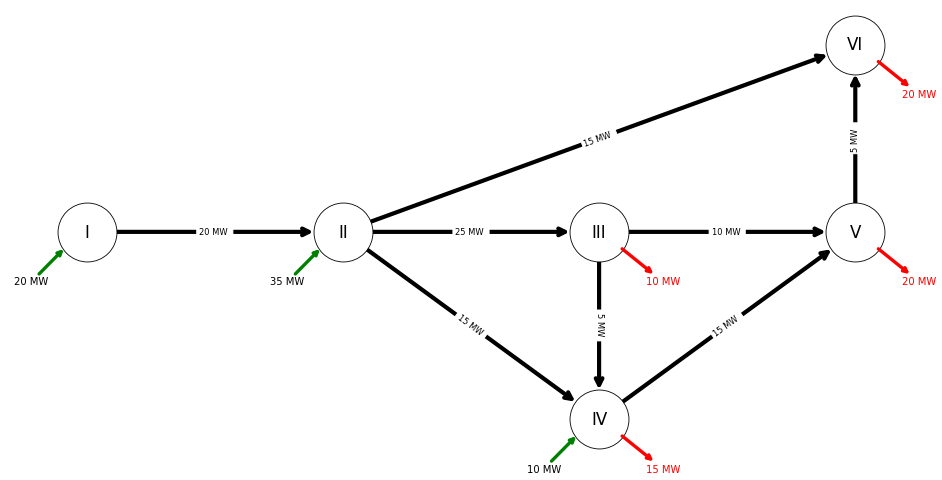

In [20]:
trace.plot_model()

Matrix calculations require the network flows to be in vectors. Extract them from the directed network graph

In [21]:
@patch
def _power(self:Trace):
    #total flow entering node
    self.P_IN = np.array([np.sum([self.network._adj[y][x]['TO_MW'] for y in list(self.network.predecessors(x))]) + # sum of flow entering node
                          self.network.nodes[x]['GENERATION_MW'] for x in self.network.nodes]) # Generation at the node

    # can have negative generation from say a battery charging - want to highlight this but clip to 0 to keep matrix solver happy
    if self.P_IN.min()<=-10:
        print(f'P_IN is lower than -10 :  -{self.P_IN.min()}')
    self.P_IN = self.P_IN.clip(min=.01) # clip to 0.01 to avoid numerical issues

        
    #SUM OF FLOWS LEAVING NODES
    self.P_OUT = np.array([np.sum([self.network[y][x]['FROM_MW'] for x in self.network[y]])+
                            self.network.nodes[y]['DEMAND_MW'] for y in self.network.nodes])
    if self.P_OUT.min() < 0: # should be zero or positive
        print(f'P_OUT is lower than 0 :  -{self.P_IN.min()}')
    self.P = self.P_IN

    #SUM OF GENERATION NODES
    self.P_G = np.array([self.network.nodes[x]['GENERATION_MW'] for x in self.network.nodes])
                            
    # SUM OF DEMAND AT NODES
    self.P_D =  np.array([self.network.nodes[x]['DEMAND_MW'] for x in self.network.nodes])

    self.F_recieve = np.array([self.network._adj[x[0]][x[1]]['TO_MW'] for x in self.network.edges])
    self.F_send = np.array([self.network._adj[x[0]][x[1]]['FROM_MW'] for x in self.network.edges])
    return

In [22]:
trace._power()

Can check the trace against the Bialek sample network.

In [23]:
assert(trace.P == np.array([20., 55., 25., 30., 25., 20.])).all()
assert(trace.P_G == np.array([20, 35,  0, 10,  0,  0])).all()
assert(trace.P_D == np.array([ 0,  0, 10, 15, 20, 20])).all()
assert(trace.F_send == np.array([20, 25, 15, 15, 10,  5, 15,  5])).all() #note that the order is different from the paper
assert(trace.F_recieve == np.array([20, 25, 15, 15, 10,  5, 15,  5])).all()

In [24]:
@patch
def _matrix(self:Trace):
    self.m =len(self.F_recieve)
    self.nbus = len(self.P)

    #SET UP THE NODE ID DICTIONARY
    self.node_id = {x:i for i, x in enumerate(self.network.nodes)}
    self.id_node = {i:x for i, x in enumerate(self.network.nodes)}
    ## incidence matrix B (1)    
    self.B = np.zeros([self.m, self.nbus])
    for n,x in enumerate(self.network.edges):
        self.B[n,self.node_id[x[0]]] = 1
        self.B[n,self.node_id[x[1]]] = -1

    self.B_u = np.where(self.B<0,-1,0)
    self.B_d = np.where(self.B>0,1,0)
        
    #adjacency matrix [no_buses x no_buses]
    self.C = -self.B_d.T@self.B_u

    diag_f_recieve = np.eye(self.m)*self.F_recieve
    diag_f_send = np.eye(self.m)*self.F_send
        
#         self.Fd = -self.B_d.T @ diag_f @ self.B_u
    self.Fd_recieve = -self.B_d.T @ diag_f_recieve @ self.B_u
    self.Fd_send = -self.B_d.T @ diag_f_send @ self.B_u
        
    diag_p = np.eye(self.nbus) * self.P
    
    self.A_d = np.eye(self.nbus) + self.B_d.T @ diag_f_recieve @ self.B_u @ inv(diag_p)
    self.A_u = np.eye(self.nbus) + self.B_u.T @ diag_f_send    @ self.B_d @ inv(diag_p)
        
    self.net_matrix =   (np.array([(self.P_G / self.P)]).T * (inv(self.A_d) * self.P_D))
    self.gross_matrix = (np.array([(self.P_D / self.P)]).T * (inv(self.A_u) * self.P_G))

@patch
def _make_df(self:Trace):
    self.df = pd.DataFrame(np.concatenate([self.net_matrix, self.gross_matrix.T], axis=1), 
                    columns = [ x + '_net' for x in self.network.nodes] + [ x +'_gross' for x in self.network.nodes])
    self.df.insert(loc=0, column='GENERATION', value=self.network.nodes)

    # self.df = self.df.loc[self.df.sum(axis=1)!=0,self.df.sum(axis=0)!=0]
    return self.df

In [25]:
trace._matrix()
trace._make_df()

,GENERATION,I_net,II_net,III_net,IV_net,V_net,VI_net,I_gross,II_gross,III_gross,IV_gross,V_gross,VI_gross
0,I,0.0,0.0,3.636364,3.636364,5.818182,6.909091,0.0,0.0,3.636364,3.636364,5.818182,6.909091
1,II,0.0,0.0,6.363636,6.363636,10.181818,12.090909,0.0,0.0,6.363636,6.363636,10.181818,12.090909
2,III,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,IV,0.0,0.0,0.000000,5.000000,4.000000,1.000000,0.0,0.0,0.000000,5.000000,4.000000,1.000000
4,V,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
5,VI,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [57]:
#| export
@patch
def plot_node(self:Trace, node:str):
    fig = plt.figure(1, figsize=(20, 10), dpi=60)
    sub_net_nodes = list(trace.network.predecessors(node))+list(trace.network.successors(node))+[node]
    sub_net = nx.subgraph(self.network, sub_net_nodes)
    options = {
        "font_size": 20,
        "font_color":'black',
        "node_size": 5000,
        "node_color": 'white',
        "edge_cmap": "cm.magma",
        "edgecolors": 'black',
        "arrowstyle":"->",
        "arrowsize":20,
        "width":5,
        }
    pos = {'I':(0,0),
           'II':(.5,0),
           'III':(1,0),
           'IV':(1,-.5),
           'V':(1.5,0),
           'VI':(1.5,.5)}

    tmp = nx.draw_networkx(sub_net, pos=pos, **options)
    for x in sub_net.nodes:
        #GENERATION
        if sub_net.nodes[x]['GENERATION_MW'] > 0:
            plt.annotate(f'{round(sub_net.nodes[x]["GENERATION_MW"],1)} MW', 
                            xy=(pos[x][0]-.06*np.sin(np.pi/4),
                                pos[x][1]-.06*np.cos(np.pi/4)), 
                            xytext=(pos[x][0]-.2*np.sin(np.pi/4),
                                    pos[x][1]-.2*np.cos(np.pi/4)),
                                color='black',
                                fontsize=12,
                            arrowprops=dict(arrowstyle="->", 
                                            lw=4, 
                                            color="g"))

        #DEMAND
        if sub_net.nodes[x]['DEMAND_MW'] > 0:
            plt.annotate(f'{round(sub_net.nodes[x]["DEMAND_MW"],1)} MW', 
                        xy=(pos[x][0]+.06*np.sin(np.pi/4),
                            pos[x][1]-.06*np.cos(np.pi/4)), 
                        xytext=(pos[x][0]+.2*np.sin(np.pi/4)-.05,
                                pos[x][1]-.2*np.cos(np.pi/4)),
                        color='r',fontsize=12,
                        arrowprops=dict(arrowstyle="<-", 
                    lw=4, color="red"))

    edge_labels = {}
    for x in sub_net.edges:
        tmp = trace.network.edges[x]
        edge_labels[x] = f'{str(tmp["FROM_MW"])} MW ' if tmp["FROM_MW"]==tmp["TO_MW"] else f'{str(round(tmp["FROM_MW"],1))} MW / {str(round(tmp["TO_MW"],1))} MW '

    nx.draw_networkx_edge_labels(
            sub_net, pos,
            edge_labels=edge_labels,
            font_color='black',
            font_size =10
        )
    plt.axis("off")
    return plt

<module 'matplotlib.pyplot' from '/opt/python/3.10.4/lib/python3.10/site-packages/matplotlib/pyplot.py'>

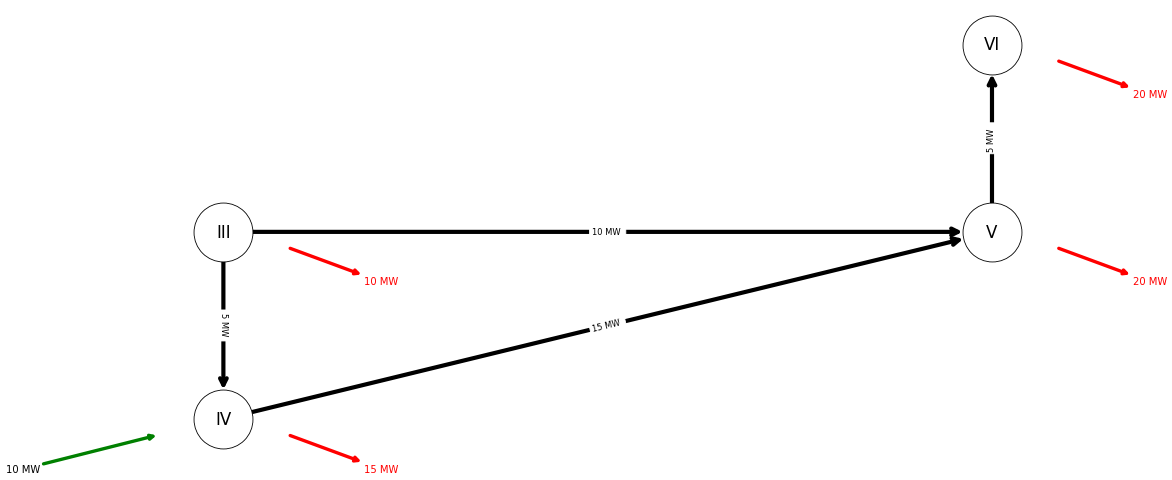

In [59]:
trace.plot_node('V')